# Multi-layer perceptrons

### Outline
1. The MLP architecture
2. Overview of tensors
3. PyTorch implementation

## 1. Multi-layer perceptrons

### Some models we've seen so far

Suppose we have a regression of classification task, and a labelled dataset with $n$ continuous features. So, we have:
\begin{equation*}
    \textup{Input space} = \mathbb{R}^{n},
\end{equation*}
where each input vector is of the form $x = (x_1,\dotsc,x_n)$.

We've seen a few different parametric models. 

1. **Linear regression** (regression tasks):
    - Output space: $\mathbb{R}$
    - Parameter space: $\mathbb{R}^{n+1}$ (the parameters are a pair $(w,b)$, where $w \in \mathbb{R}^n$ is a weight vector and $b\in \mathbb{R}$ is a bias term).
    - Model: Defined as $F(x;w,b) = w^T x + b$. Visually:
    \begin{equation*}
        \mathbb{R}^n \xrightarrow{\text{linear}} \mathbb{R}.
    \end{equation*}
2. **Perceptron** (binary classification tasks):
    - Output space: $\{0,1\}$ (represents the class label)
    - Parameter space: $\mathbb{R}^{n+1}$ (same as linear regression).
    - Model: Defined as $F(x;w,b) = H(w^T x + b)$, where $H$ is the Heaviside step function. Visually, it is the composition:
    \begin{equation*}
        \mathbb{R}^n \xrightarrow{\text{linear}} \mathbb{R} \xrightarrow{H} \{0,1\}.
    \end{equation*}
3. **Logistic regression (soft)** (binary classification tasks):
    - Output space: The open interval $(0,1)$ (represents the probability that $Y=1$)
    - Parameter space: $\mathbb{R}^{n+1}$ (same as linear regression).
    - Model: Defined as $F(x;w,b) = \sigma(w^T x + b)$, where $\sigma$ is the sigmoid function. Visually, it is a composition:
    \begin{equation*}
        \mathbb{R}^n \xrightarrow{\text{linear}} \mathbb{R} \xrightarrow{\sigma} (0,1).
    \end{equation*}
4. **Multi-variate linear regression** (regression tasks):
    - Output space: $\mathbb{R}^h$ (represents the $h$-dimensional output)
    - Parameter space: $\mathbb{R}^{h \times (n+1)} \times \mathbb{R}^h$ (the parameters are a pair $(W,b)$, where $W\in \R^{h\times (n+1)}$ is a weight matrix and $b\in \R^h$ is a bias vector).
    - Model: Defined as $F(x;W,b) = W^T x + b$. Visually:
    \begin{equation*}
        \mathbb{R}^n \xrightarrow{\text{linear}} \mathbb{R}^h.
    \end{equation*}
5. **Softmax regression** (multi-class classification tasks):
    - Output space: The probability simplex $\Delta_k$ (where $k$ is the number of classes)
    - Parameter space: $\mathbb{R}^{k \times (n+1)} \times \mathbb{R}^k$ (same as multi-variate linear regression).
    - Model: Defined as $F(x;W,b) = S(W^T x + b)$, where $S$ is the softmax function. Visually, it is a composition:
    \begin{equation*}
        \mathbb{R}^n \xrightarrow{\text{linear}} \mathbb{R}^k \xrightarrow{S} \Delta_k.
    \end{equation*}

    You might notice two things:
    - The parameters in all the models arise from a "piece" of the model which is a linear (more precisely, affine) map.
    - For classification tasks in which the output space is in someway constrained (a probability simplex for soft classification, or the finite set of class labels for hard classification), the model has a non-linear component which is responsible for squishing the input down into the constrained space.

    It turns out that if you do more complex mixtures of linear and non-linear maps, then you (almost like magic) get models with a lot more expressive power, in the sense that the model can successfully approximate a much wider range of functions. This is the idea behind **multi-layer perceptrons** (MLPs), also known as **feed-forward neural networks**. These are the simplest kind of neural network, and are the building blocks for more complex architectures.

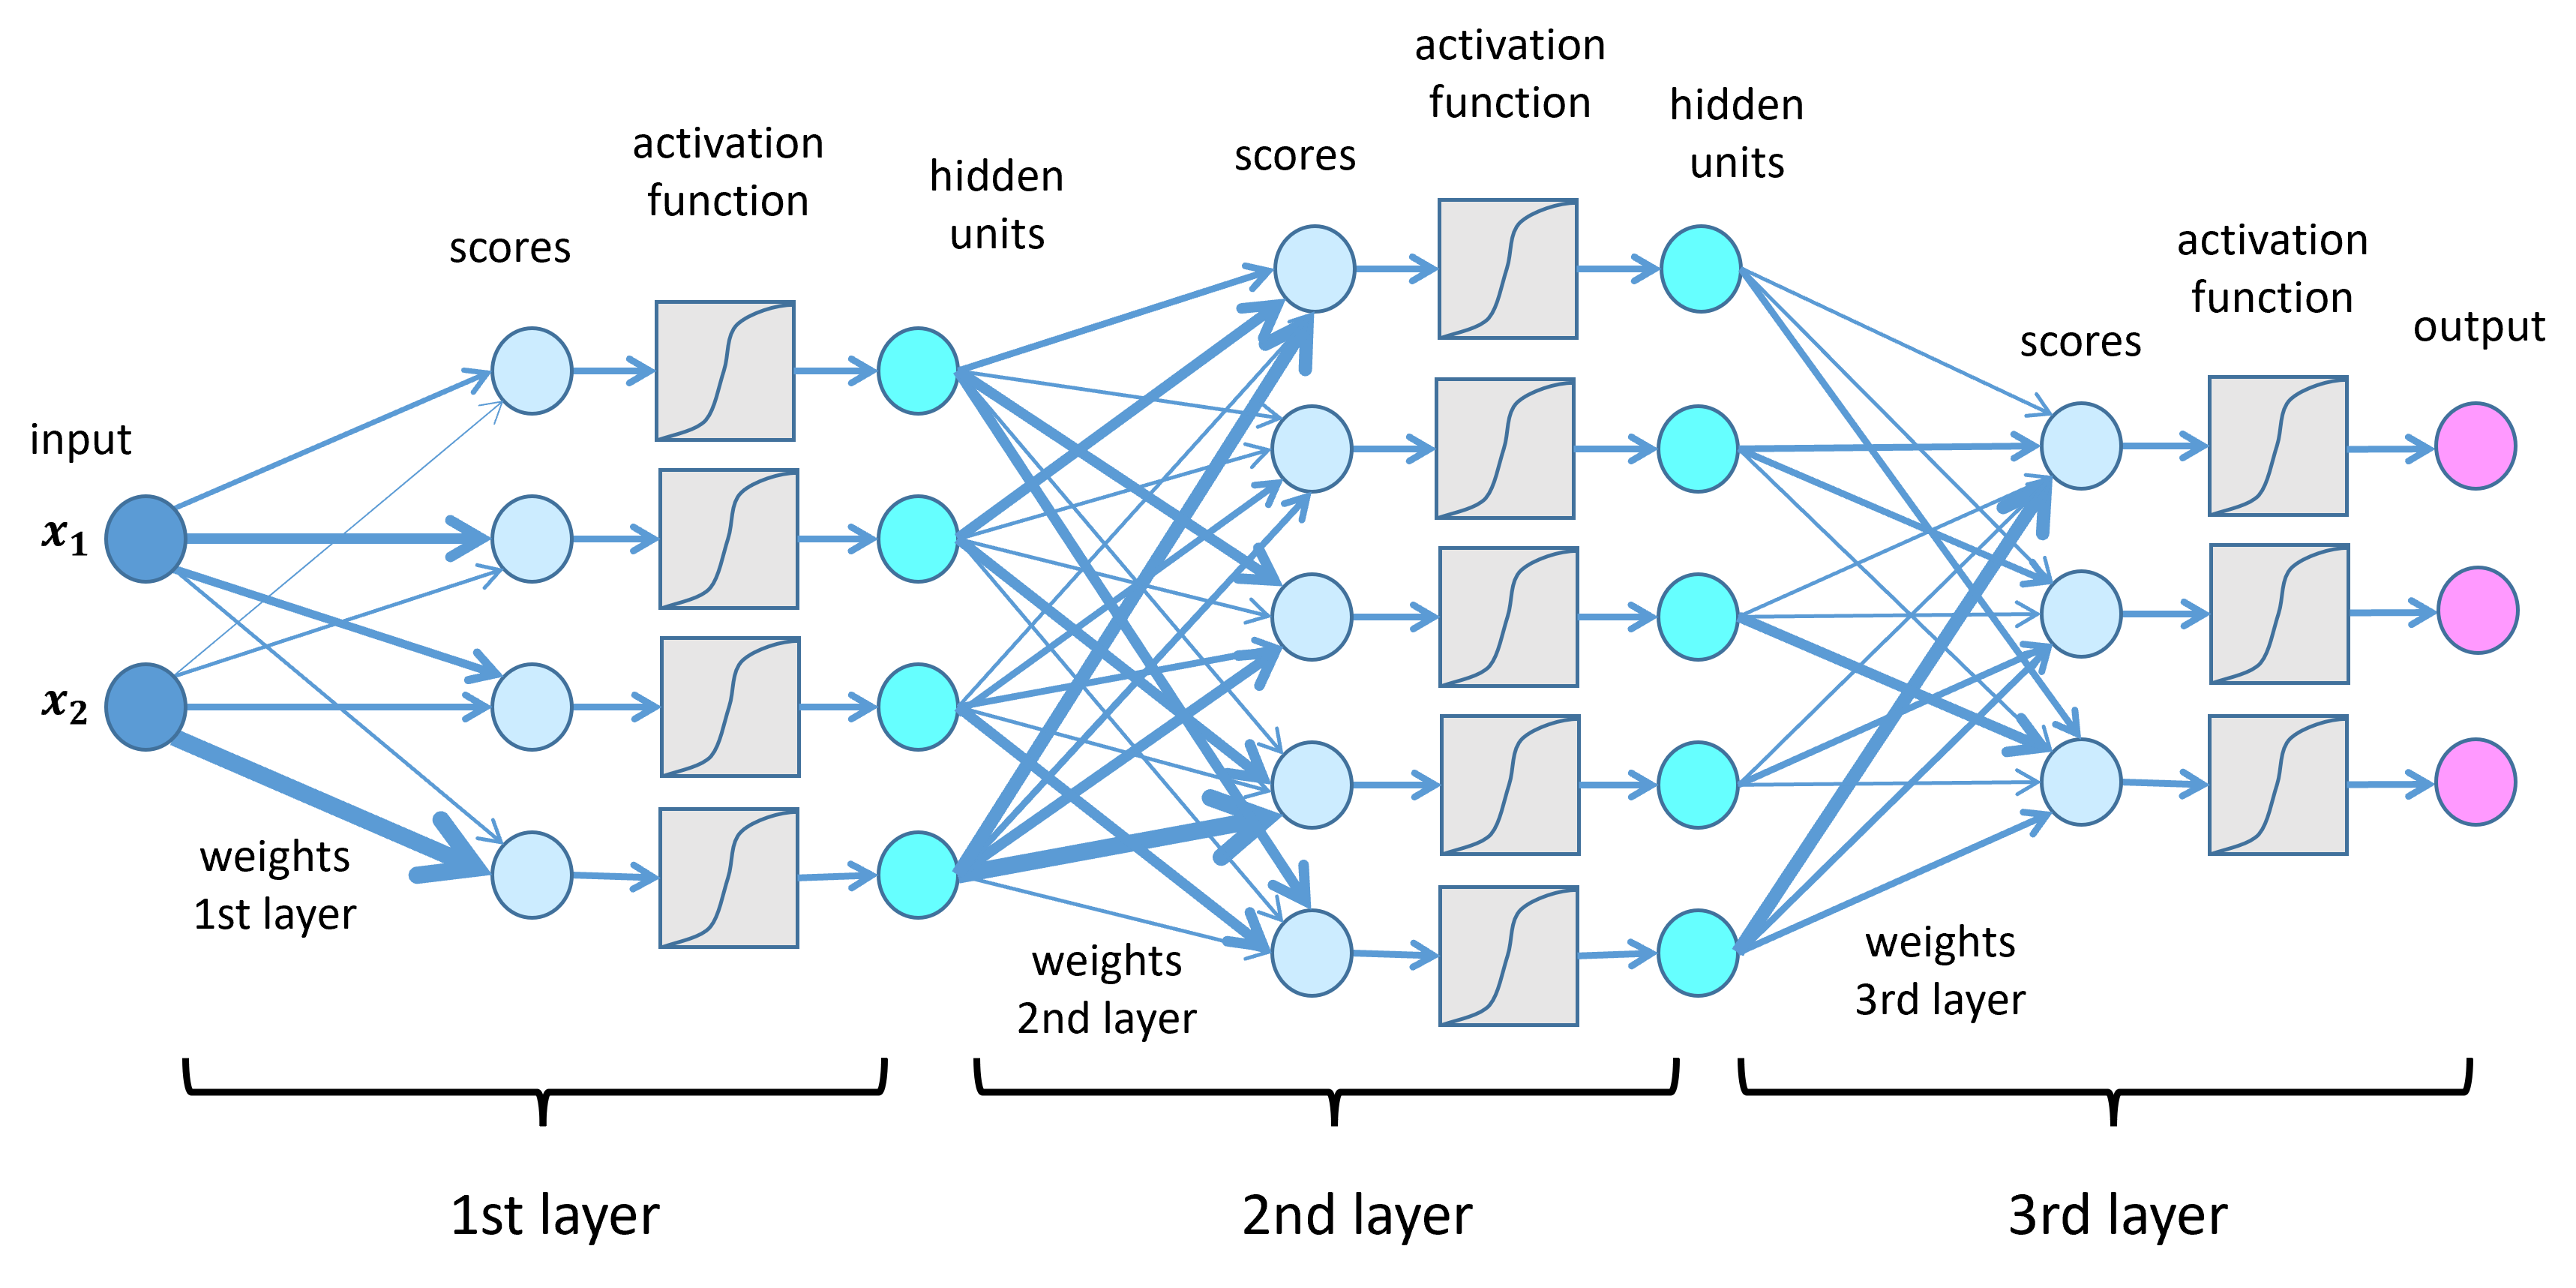

In [45]:
from IPython.display import Image, display

display(Image('assets/Neural networks - Lamarr Institute.png'))

### What is a neural network?
Neural networks are a generalization of the above models, which mix linear functions with non-linear functions in a sequential manner:
\begin{align*}
    (\textup{input space}) & \xrightarrow{\textup{linear}} \mathbb{R}^{h_1} \xrightarrow{\textup{non-linear}} \mathbb{R}^{h_1} \xrightarrow{\textup{linear}} \mathbb{R}^{h_2} \xrightarrow{\textup{non-linear}} \mathbb{R}^{h_2} \to \dotsb \to (\textup{output space}).
\end{align*}
Some terminology:
- The input space (usually some $\mathbb{R}^n$) is the **input layer**.
- The output space (usually some $\mathbb{R}^k$ or $\Delta_k$) is the **output layer**.
- The intermediate $\mathbb{R}^{h_i}$ are the **hidden layers**.
- The number of layers is called the **depth** of the network.
- The number of hidden units in the $i$-th layer, i.e. $h_i$, is called the **width** of the $i$-th layer.
- The non-linear functions in between the linear functions are called **activation functions** (typically, the same activation function is used for all layers).
- The parameters of the network are the weights and biases of the linear functions, as well as the parameters of the activation functions (if any). Collectively, they are all referred to as the weights of the network.

**Remark.** The activation function actually refers to a single-variable function $A: \mathbb{R} \to \mathbb{R}$. The notation $A:\mathbb{R}^h \to \mathbb{R}^h$ above means that this single-variable function is applied to each component of the input vector, resulting in an output vector of the same shape. 

Some common activation functions are:
- **ReLU**: $A(x) = \max\{0,x\}$.
- **Sigmoid**: $A(x) = \frac{1}{1+e^{-x}}$.
- **Tanh**: $A(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$.

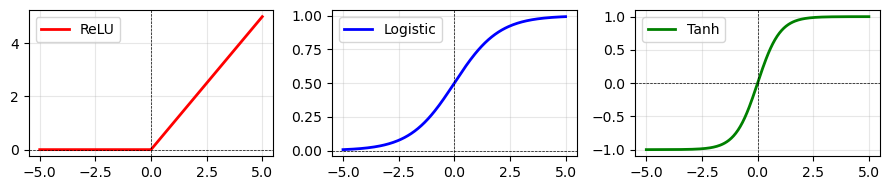

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Create input values
x = np.linspace(-5, 5, 200)

# Create figure with 3 subplots in one row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9,2),)

# Plot ReLU
relu = np.maximum(0, x)
ax1.plot(x, relu, 'r-', linewidth=2, label='ReLU')

# Plot Logistic (Sigmoid)
logistic = 1 / (1 + np.exp(-x))
ax2.plot(x, logistic, 'b-', linewidth=2, label='Logistic')

# Plot Tanh
ax3.plot(x, np.tanh(x), 'g-', linewidth=2, label='Tanh')

# add legends, grids and axes
for ax in (ax1, ax2, ax3):
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax.axvline(0, color='black', linewidth=0.5, linestyle='--')

# Adjust layout and display
plt.tight_layout()
plt.show()

### Function approximation
Recall that in (supervised) ML we want to construct/define/build a function $F$ that approximates some ground truth function $\mathbf{F}$ (mapping features to targets) by *learning* from some labelled dataset $\mathcal{D}$. But: 

*What exactly does it mean to approximate a function?* 

I find a geometric perspective very useful:

The ground truth function $\mathbf{F}$ should be thought of as a single element/point in a gigantic space of functions (for example, all continuous functions from the unit cube in $\mathbb{R}^n$ to $\mathbb{R}^m$). The function $F$ that we wish to construct is another element of this space of functions, which is in some sense close to the ground truth function $\mathbf{F}$ while simultaneously being easy to compute or work with.

To make sense of "close", we need a notion of distance between functions in our space of functions, also called a **norm** or **metric**. There are many ways to define a distance between functions:
- $L_{\infty}$-norm: The distance of $F$ from $\mathbf{F}$ is the largest individual distance on any input.
- $L_1$-norm: The distance of $F$ from $\mathbf{F}$ is the average distance on all inputs.
- $L_2$-norm: The distance of $F$ from $\mathbf{F}$ is the average squared distance on all inputs.

Now, in order to search for a function $F$ that can potentially approximate $\mathbf{F}$, we restrict our candidates for $F$ to a subset of the space of functions- these are models! The goal then is to find a subset (i.e. model) that is **dense** in the function space, which means that for any function $\mathbf{F}$, there is a function $F$ in the model that is arbitrrily close to $\mathbf{F}$. (This is exactly analogous to the statement that the rational numbers are dense within the real numbers, i.e. any real number can be approximated with arbitrary precision by a ratio of integers- simply truncate the decimal representation to a suitable length!) 

**Remark.** Note that in order to train a model to "learn from data", what we need is way to measure the distance between the model and the ground truth function *on the given data*. This is nothing but the **loss function**. So, you can think of the loss function as an approximate measure of the distance between $F$ and $\mathbf{F}$ in the abstract function space. As we train the model, we are tuning the paramaters in such a way that our $F$ gets closer to $\mathbf{F}$ on the data.

### Universal approximators
A **universal approximator** refers to a model that is dense in some chosen space of functions. In other words, it is a model that can approximate any function within the space with arbitrary precision (relative to some fixed norm on the space).

**(Non) Examples**: Suppose we are working in the space $\mathcal{F}$ of all continuous functions from $[0,1]$ to $\mathbb{R}$, and suppose our (for simplicity) that our ground truth function is $\mathbf{F}(x) = \sin x$.  Any "point" in $\mathcal{F}$ corresponds to some continuous graph above the unit interval, and the graph of $\sin x$ is our fixed target "point" in $\mathcal{F}$. Calling a model (i.e. a  class of continuous functions on $[0,1]$) a universal approximator means that for any continuous graph living over the unit interval, we can tweak the parameters of the model to get a graph that is arbitrarily close to that of $\sin x$. Thus:
- The linear model is not a universal approximator; no matter how we draw a straight line over the unit interval, it will never be able to approximate the graph of $\sin x$ (in any norm). 
- The logistic regression model is not a universal approximator. For example, no sigmoidal shaped function can hope to approximate the function $\mathbf{F}(x) = \sin x$ (in any norm).


**Example**: The **Stone-Weierstrass Theorem** says that polynomial functions are universal approximators within the space of continuous functions on any closed interval $[a,b]$ (with respect to the $L_{\infty}$ norm). This means that for any continuous $\mathbf{F}:[a,b]\to \mathbb{R}$ and any error $\epsilon > 0$, there is a polynomial $F(x)$ such that the vertical gap between $F$ and $\mathbf{F}$ is less than $\epsilon$ (at all points in the interval). 

To build an approximation, you could (for instance) sample a bunch of points on the graph of $\mathbf{F}$ over the interval and use Lagrange Interpolation to construct a polynomial that passes through all of those points. By sampling more and more points (which results in increasing the degree of the interpolating polynomial), you can get the vertical distance between the graphs of $F$ and $\mathbf{F}$ to be as small as you like!

### Universal approximation theorem (UAT)
These are theoretical results that say that neural networks (in particular, multi-layer percpetrons) with certain characteristics are universal function approximators. In particular the three papers below all prove that neural networks with a single hidden layer are universal approximators (w.r.t. $L_{\infty}$-norm) in the space of coninuous functions from any compact subset of $\mathbb{R}^n$ to $\mathbb{R}^m$:
- (Cybenko, 1989): https://link.springer.com/article/10.1007/BF02551274
- (Funahashi, 1989): https://www.sciencedirect.com/science/article/abs/pii/0893608089900038?via%3Dihub
- (Hornik, Stitchcombe, White, 1991): https://www.sciencedirect.com/science/article/abs/pii/0893608089900208

The first two papers prove the result for sigmoidal activation functions, and the third generalizes to a wider class of activation functions. For precise versions of this statement, check out the respective links above. Another useful starting point is the wikipedia page on the UAT: https://en.wikipedia.org/wiki/Universal_approximation_theorem

**Remark.** The UAT is a theoretical result, and it does not say anything about the practical ability of a neural network to approximate a function. In particular, it does not say anything about the ability of a neural network to learn from data. It is simply a statement that there exists a neural network that can approximate any function (in some sense), so it is telling us that, at the very least, we are not theoretically limited by the choice of a neural network model. 

### Theory vs. practice

The UAT provides a theoretical basis to tentatively *believe* that neural networks will be useful for a wide range of machine learning tasks. Yet, although these were proved a long time ago, neural networks did not really gain traction and wide-spread acceptance until the 2000s. This was because, although people tried to use them for various ML tasks, in practice they were not able to perform as well as other (more traditional) models. It is known now with the benefit of hindsight that one reason for this was that the networks were not trained on large enough datasets. 

A turning point in the history of neural networks was the introduction of **deep learning** in 2012, which is a subfield of ML that focuses on training large neural networks on large datasets. One milestone frequently cited as being (perhaps) the most influential was the **ImageNet** competition, which was a large-scale image classification challenge. The winning entry in 2012 was a deep neural network called **AlexNet** (designed and trained by Sutskever, Krizhevsky, and Hinton), which achieved a significant improvement over the previous state-of-the-art. This success led to a surge of interest in deep learning and neural networks, and they have since become the dominant approach in many areas of ML.

Note that one reason why scalability is feasible for neural networks is that the computations involved in training (model fitting) and inference (prediction) are highly parallelizable. In particular, the linear parts of the network are matrix multiplications that can be handle very fast by GPUs. 

## Example: approximating $\sin x$ with an MLP
Let's see how we can use an MLP to approximate the function $\mathbf{F}(x) = \sin x$ on the interval $[0,1]$. We will use a single hidden layer 

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Generate training data
x = np.linspace(-2*np.pi, 2*np.pi, 1000).reshape(-1, 1)
y = np.sin(x)

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split into training and validation sets (80/20 split)
num_samples = x_tensor.shape[0]
split_idx = int(0.8 * num_samples)
x_train_tensor = x_tensor[:split_idx]
y_train_tensor = y_tensor[:split_idx]
x_val_tensor   = x_tensor[split_idx:]
y_val_tensor   = y_tensor[split_idx:]

# Define the neural network
class SineApproximator(nn.Module):
    def __init__(self):
        super(SineApproximator, self).__init__() 
        self.hidden = nn.Linear(1, 15)  # Hidden layer with 20 neurons
        self.activation = nn.Tanh()      # Tanh activation
        self.output = nn.Linear(15, 1)   # Output layer

    def forward(self, x):
        x = self.hidden(x) # First linear layer
        x = self.activation(x) # Activation function
        x = self.output(x) # Second linear layer (i.e. output layer)
        return x
    
# Initialize the model
model = SineApproximator() 

# Choose MSE as loss function
criterion = nn.MSELoss() 

# Choose algorithm for optimizing the weights (we use Adam, a particular implementation of gradient descent)
optimizer = optim.Adam(model.parameters(), # parameters to optimize
                       lr=0.01 # learning rate for gradient descent
                       ) 

In [48]:
# Training loop and early stopping (hyper)-parameters
num_epochs = 1000
patience = 100         # Number of epochs to wait for improvement
min_delta = 1e-4      # Minimum change in the validation loss to qualify as an improvement
best_val_loss = np.inf # Initialize best validation loss
patience_counter = 0 # Counter for early stopping

train_losses = [] # List to store training losses
val_losses = [] # List to store validation losses

Epoch 100: Train Loss = 0.050771, Val Loss = 0.186132
Epoch 200: Train Loss = 0.030691, Val Loss = 0.153490
Early stopping at epoch 279


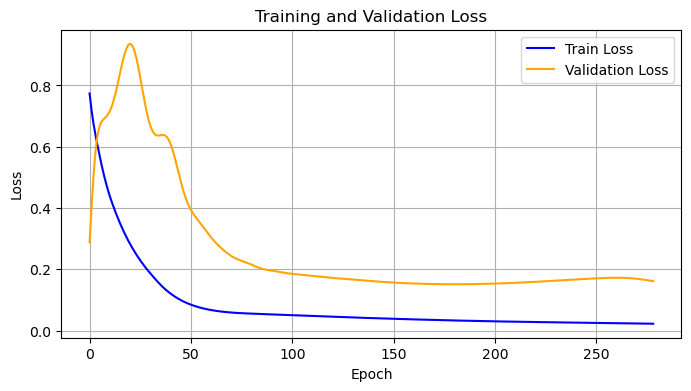

In [49]:
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()

    # Zero out the gradients before each new epoch
    optimizer.zero_grad()

    # Make predictions; same as doing y_pred = model(x_train_tensor)
    y_pred = model(x_train_tensor)

    # Calculate the loss on training data
    train_loss = criterion(y_pred, y_train_tensor)

    # Compute gradients of loss with respect to model parameters
    train_loss.backward()

    # Update model parameters using the optimizer
    optimizer.step()
    
    # Set the model to evaluation mode
    model.eval()

    # Calculate validation loss
    with torch.no_grad(): # No need to track gradients for validation
        val_pred = model(x_val_tensor)
        val_loss = criterion(val_pred, y_val_tensor)
    
    # Store losses for plotting
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    
    # Print training and validation loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1:03d}: Train Loss = {train_loss.item():.6f}, Val Loss = {val_loss.item():.6f}")

    # Check for improvement
    if best_val_loss - val_loss.item() > min_delta:
        best_val_loss = val_loss.item()
        patience_counter = 0  # Reset counter if validation loss improves
    else:
        patience_counter += 1
    
    # Early stopping condition
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Plot training and validation loss
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(train_losses, label='Train Loss', color='blue')
ax.plot(val_losses, label='Validation Loss', color='orange')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
ax.legend()
ax.grid(True)
plt.show()

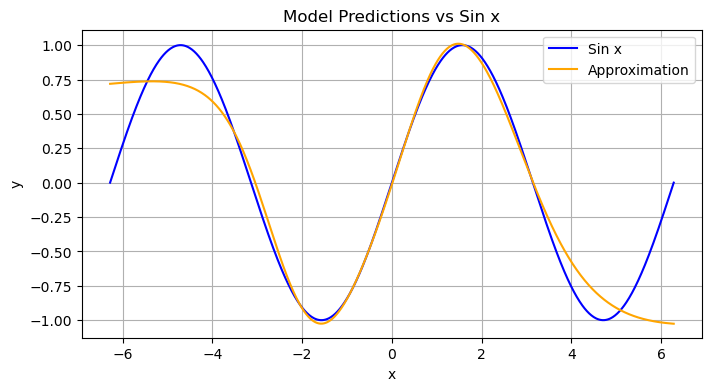

In [50]:
# Plot the model's predictions vs sin x

# generate predictions
model.eval() # Set model to evaluation mode
with torch.no_grad():
    y_pred = model(x_tensor) # get a tensor of predictions
    y_pred = y_pred.numpy() # convert to numpy array

# Plot the results
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, y, label='Sin x', color='blue')
ax.plot(x, y_pred, label='Approximation', color='orange')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Model Predictions vs Sin x')
ax.legend()
ax.grid(True)
plt.show()
